# Face Detection Use MTCNN on Image


## Connect to EvaDB

In [50]:
%pip install --quiet "evadb[vision,notebook]"
%pip install --quiet facenet_pytorch
import evadb
cursor = evadb.connect().cursor()
import warnings
warnings.filterwarnings("ignore")

## Import Images into EvaDB

In [80]:
cursor.query("DROP TABLE IF EXISTS Cheer;").df()
cursor.query("LOAD IMAGE '/content/image.jpg' INTO Cheer;").df()

,0
0,Number of loaded IMAGE: 1


## Creat Function Face Detector

In [55]:
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/functions/face_detector.py

File ‘face_detector.py’ already there; not retrieving.



In [57]:
cursor.query("""
    CREATE FUNCTION IF NOT EXISTS FaceDetector
    INPUT  (image NDARRAY UINT8(3, ANYDIM, ANYDIM))
    OUTPUT (bboxes NDARRAY FLOAT32(ANYDIM, 4),
          scores NDARRAY FLOAT32(ANYDIM))
    TYPE  FaceDetection
    IMPL  'face_detector.py';
""").df()

,0
0,Function FaceDetector added to the database.


# Face detector Use MTCNN

In [58]:
cursor.query("SELECT FaceDetector(data) FROM Cheer").df()

,bboxes,scores
0,"[[793, 250, 890, 394], [606, 290, 693, 396], [...","[0.9999991655349731, 0.9999886751174927, 0.999..."


In [71]:
response = cursor.query("""
  SELECT bboxes, conf
  FROM Cheer JOIN LATERAL UNNEST(FaceDetector(data)) AS Face(bboxes, conf)
""").df()
response

,bboxes,conf
0,"[793, 250, 890, 394]",0.999999
1,"[606, 290, 693, 396]",0.999989
2,"[441, 292, 520, 393]",0.999999
3,"[247, 348, 306, 434]",1.0
4,"[443, 413, 473, 449]",0.713573
5,"[463, 398, 489, 427]",0.757211


## Plot Face Detection result

In [77]:
import cv2
from matplotlib import pyplot as plt

def annotate_image(detections, input_image_path, output_image_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    image = cv2.imread(input_image_path)

    for index, row in detections.iterrows():
        box = row['bboxes']
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        # object bbox
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color1, thickness)
        # frame label
        cv2.putText(image, f'Face ID: {index}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color2, thickness)

    cv2.imwrite(output_image_path, image)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

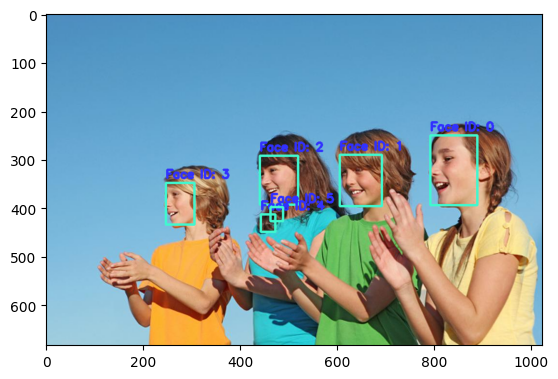

In [79]:
from ipywidgets import Video, Image
input_path = '/content/image.jpg'
output_path = 'output.jpg'

annotate_image(response, input_path, output_path)

## Drop Face Detector Function

In [53]:
cursor.query("DROP FUNCTION FaceDetector").df()

,0
0,Function FaceDetector successfully dropped
